In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
num_doc_per_version = 50

In [23]:
%matplotlib inline
import os
from glob import glob
import re
import pandas as pd
from pyhocon import ConfigFactory
from cort.core.corpora import Corpus
import urllib
from IPython.core.display import display, HTML
from mturk.score_submissions import evaluate_submissions, adhoc_fix
from mturk.gformtools import visualize, extract_errors, unpack_json, chains_str_from_events
from collections import Counter
from tqdm import tqdm
import seaborn as sns

In [4]:
anns_paths = ['../data/annotations/Coref-annotation.csv',
              '../data/annotations/Coref-annotation-too-long.csv']
anns_gform = pd.concat([pd.read_csv(adhoc_fix(p)) for p in anns_paths], sort=False)
anns_gform = anns_gform.drop_duplicates(['Document', 'Username'], keep='last')
anns_chains = anns_gform.Annotations.apply(unpack_json)
anns = pd.concat([anns_gform, anns_chains], axis=1)
# there's no difference between using auto or gold because humans don't see our syntactic and semantic annotations
# some *.auto_conll files are missing so I replace them with the *.gold_conll equivalence
anns['conll_file'] = anns.conll_file.str.replace('auto_conll', 'gold_conll')
anns['transformation'] = anns.conll_file.str.extract(r'/([\w-]+)/\s*(?:dev|test)')

In [5]:
from glob import glob

In [6]:
def find_actual_conll_file(doc):
    path, = [s for s in glob('../output/mturk/*/%s' %doc) if '.bak' not in s]
    with open(path) as f:
        s = f.read()
    conll_file, = re.findall(r'name="conll_file" value="([\w\d/\-\.]+)"', s)
    return conll_file

In [7]:
# check that the documents people annotated still match what I have on my laptop
anns['actual_conll_file'] = anns.Document.apply(find_actual_conll_file)
anns['conll_file'] = anns['conll_file'].str.replace(r'\.v2', '')
(anns['conll_file'] != anns['actual_conll_file']).sum()

0

In [8]:
anns_nonmen = anns[anns.conll_file.str.contains('orig|nonmen')].copy()

In [9]:
anns_nonmen['base_doc'] = anns_nonmen.conll_file.str.replace(r'^.+/(?:orig|nonmen_\d+)/', '')
anns_nonmen['pct_removed'] = anns_nonmen.transformation.apply(lambda s: 0 if s=='orig' else int(s.replace('nonmen_','')))

In [10]:
# we only ask annotators to summarize the version with the most information that they saw before
anns_nonmen_filtered = anns_nonmen.sort_values('pct_removed').drop_duplicates(['Username','base_doc'])

In [11]:
nonmen_sampled = (anns_nonmen_filtered.groupby(['transformation'])
                  .apply(lambda x: x.sample(num_doc_per_version) 
                                   if len(x) > num_doc_per_version else x)
                  .drop(columns=['transformation']).reset_index())

In [12]:
%%time
def find_excerpt(conll_file):
    with open('../' + conll_file) as f:
        corpus = Corpus.from_file('', f)
    doc, = corpus.documents
    tokens = ['__' if t == '<MASKED>' else t for t in doc.tokens]
    return ' '.join(tokens[:50]) + '..'

nonmen_sampled['excerpt'] = nonmen_sampled.conll_file.apply(find_excerpt)

CPU times: user 1min 21s, sys: 3.14 s, total: 1min 24s
Wall time: 1min 27s


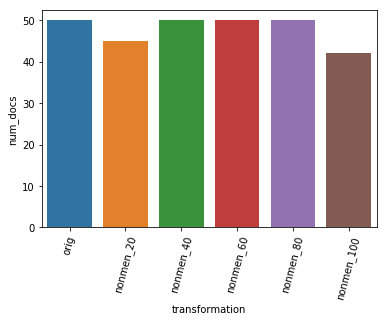

In [28]:
df = (nonmen_sampled.groupby(['transformation', 'pct_removed']).agg({'conll_file': 'count'})
      .reset_index().rename(columns={'conll_file': 'num_docs'}).sort_values('pct_removed'))
g = sns.barplot(x="transformation", y='num_docs', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
None

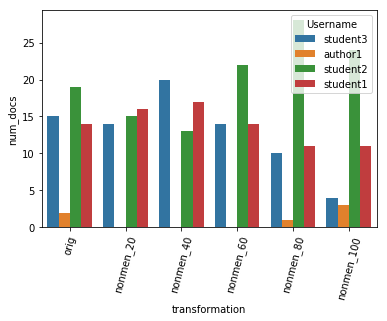

In [27]:
df = (nonmen_sampled.groupby(['Username', 'transformation', 'pct_removed']).agg({'conll_file': 'count'})
      .reset_index().rename(columns={'conll_file': 'num_docs'}).sort_values('pct_removed'))
g = sns.barplot(x="transformation", y='num_docs', hue='Username', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
None

In [15]:
data_path = '../output/summary-questions.csv'
assert not os.path.exists(data_path)
nonmen_sampled.to_csv(data_path, index=False)

In [16]:
df = pd.read_csv(data_path)

In [17]:
def format_url(row):
    prefilled_form_url_template = 'https://docs.google.com/forms/d/e/1FAIpQLSeMgrpW3NFIiZqCPYNv8UR94As1Z-9bDQ4-YhOgEY-ElGwzvw/viewform?usp=pp_url&entry.1417815352=%s&entry.950292055=%s'
    get_url = lambda row: prefilled_form_url_template %(urllib.parse.quote(row['Document']),
                                                        urllib.parse.quote(row['excerpt']))
    return '<li><a href="%s">%s</a></li>' %(get_url(row), row['Document'])

df['prefilled_form'] = df.apply(format_url, axis=1)

In [18]:
def format_url_list(df, username):
    data = df[df.Username.str.contains(username) & 
              df.Document.str.contains(username)].sample(frac=1, random_state=2352)
    s = ['<ol>'] + list(data.prefilled_form) + ['</ol>']
    display(HTML('\n'.join(s)))

In [19]:
format_url_list(df, 'student1')

In [20]:
format_url_list(df, 'student2')

In [21]:
format_url_list(df, 'student3')